# **Anomaly Detection - SetNo2**

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set the working Directory

In [2]:
import os
working_directory = "/content/drive/MyDrive/BearingAnomalyProject"
os.chdir(working_directory)

**Set No. 2**

| Index                    | Description                                                                             |
|--------------------------|-----------------------------------------------------------------------------------------|
| Recording Duration:      | February 12, 2004 10:32:39 to February 19, 2004 06:22:39                                |
| No. of Files:            | 984                                                                                     |
| No. of Channels:         | 4                                                                                       |
| Channel Arrangement:     | Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.                    |
| File Recording Interval: | Every 10 minutes                                                                        |
| File Format:             | ASCII                                                                                   |
| Description:             | At the end of the test-to-failure experiment, outer race failure occurred in bearing 1. |

Import Required Modules

In [58]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore")
sns.set(color_codes=True)
%matplotlib inline

Load Data File for Test 2, Merged

In [59]:
merged_data = pd.read_csv('ProcessedData/MergedData/DatasetBearingTest_2.csv')
merged_data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
merged_data.time = pd.to_datetime(merged_data['time'], format='%Y-%m-%d %H:%M:%S')
merged_data.index=merged_data['time']
merged_data = merged_data.sort_index()
merged_data.drop(columns=['time'], inplace=True)
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
time,,,,
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817


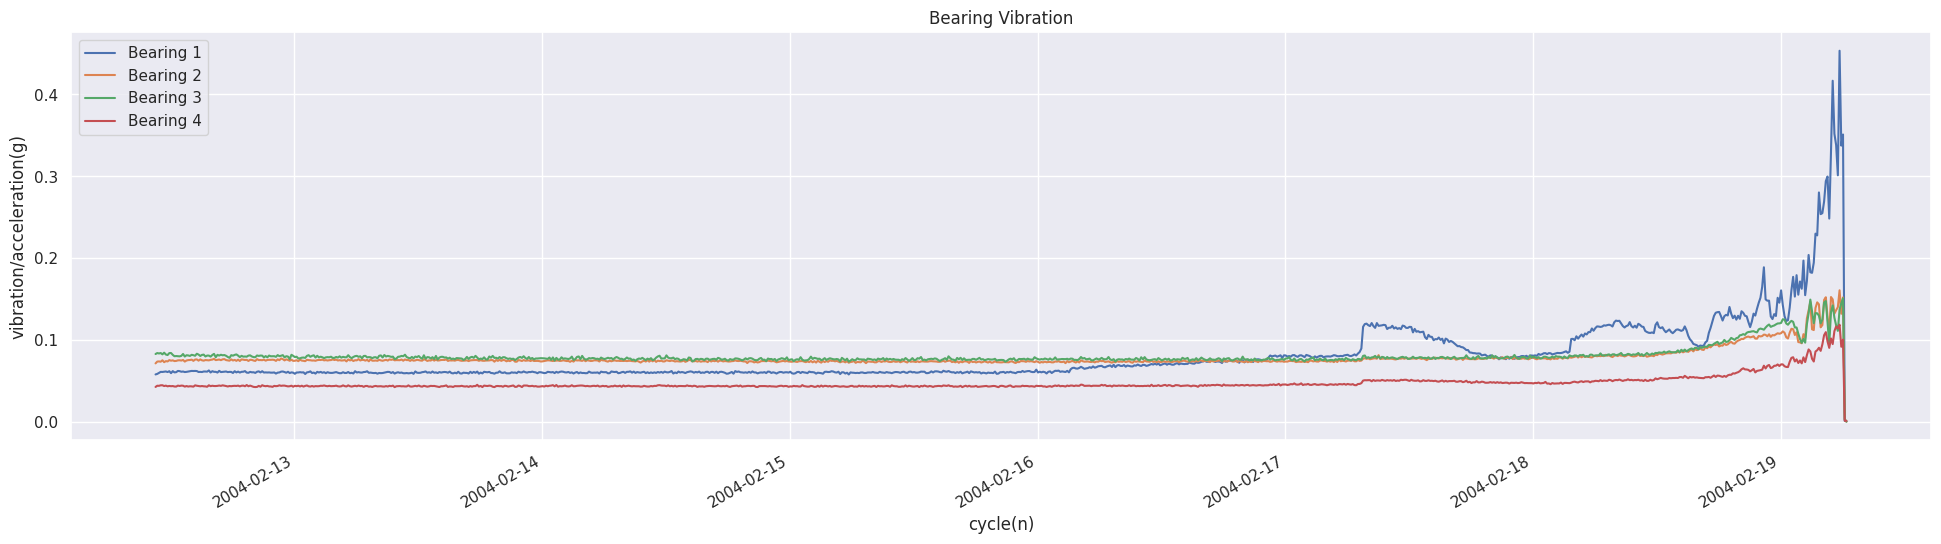

In [60]:
ax = merged_data.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

Split Data into Train and Test

In [61]:
train_data = merged_data['2004-02-12 10:32:39':'2004-02-13 23:52:39']
test_data = merged_data['2004-02-13 23:52:39':]

Normalize Data

In [62]:
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
X_test = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

Principal Component Analysis (PCA)

In [63]:
pca = PCA(n_components=2)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
X_test_pca = pd.DataFrame(pca.transform(X_test), index=X_test.index)

Mahalanobis Distance Calculation Functions

In [64]:
def mahalanobis_dist(data, inv_cov_matrix, mean_distr):
    diff = data - mean_distr
    return np.sqrt(np.sum(diff.dot(inv_cov_matrix) * diff, axis=1))

def calc_threshold(dist, extreme=False):
    k = 3 if extreme else 2
    return np.mean(dist) * k

Covariance matrix and Mahalanobis distance

In [65]:
def calculate_md(train_data, test_data):
    cov_matrix = np.cov(train_data.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean_distr = train_data.mean(axis=0)

    dist_train = mahalanobis_dist(train_data, inv_cov_matrix, mean_distr)
    dist_test = mahalanobis_dist(test_data, inv_cov_matrix, mean_distr)

    threshold = calc_threshold(dist_train, extreme=True)
    return dist_train, dist_test, threshold

Mahalanobis distance for train/test set

In [66]:
dist_train, dist_test, threshold = calculate_md(X_train_pca.values, X_test_pca.values)
threshold = math.floor(threshold)

print("Calculated threshold:", threshold)

Calculated threshold: 3


(0.0, 15.0)

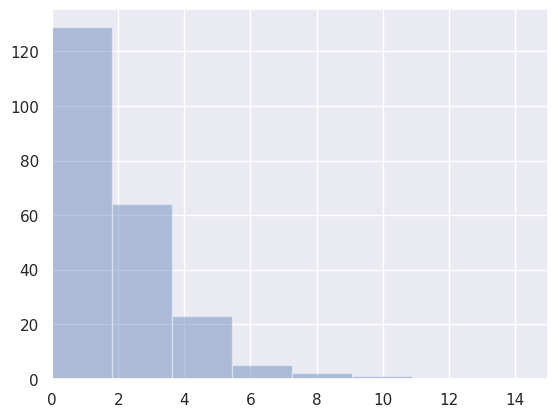

In [67]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10,
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

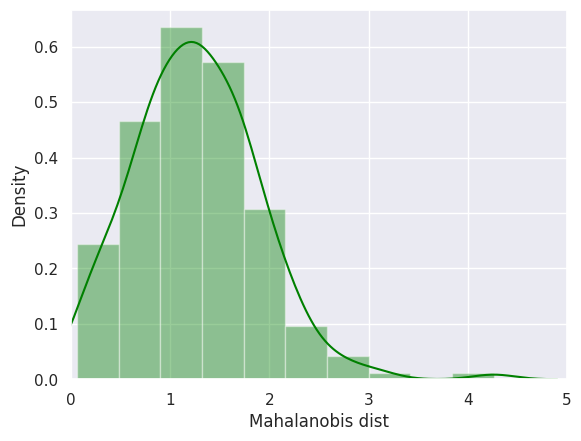

In [68]:
plt.figure()
sns.distplot(dist_train,
             bins = 10,
             kde= True,
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [69]:
anomaly_train = pd.DataFrame({'Mahalanobis Dist': dist_train, 'Threshold': threshold})
anomaly_train['Anomaly'] = anomaly_train['Mahalanobis Dist'] > threshold
anomaly_test = pd.DataFrame({'Mahalanobis Dist': dist_test, 'Threshold': threshold})
anomaly_test['Anomaly'] = anomaly_test['Mahalanobis Dist'] > threshold

In [70]:
anomaly_data = pd.concat([anomaly_train, anomaly_test])

In [89]:
# anomaly_data.index = merged_data.index

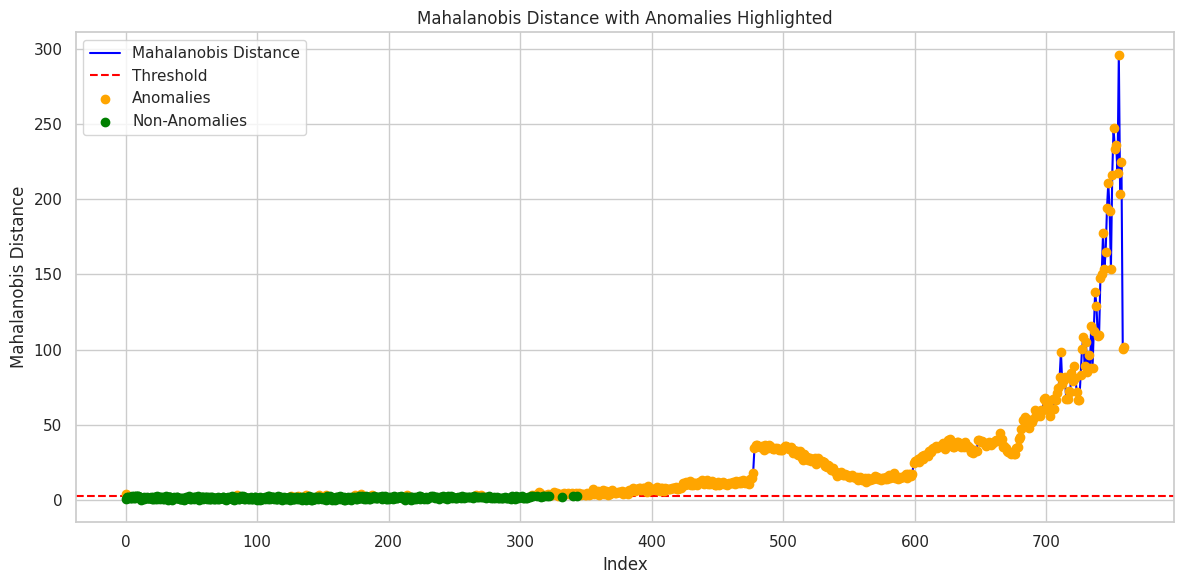

In [71]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
plt.plot(anomaly_data.index, anomaly_data['Mahalanobis Dist'], label='Mahalanobis Distance', color='blue')
plt.axhline(y=anomaly_data['Threshold'].iloc[0], color='red', linestyle='--', label='Threshold')
anomalies = anomaly_data[anomaly_data['Anomaly'] == True]
plt.scatter(anomalies.index, anomalies['Mahalanobis Dist'], color='orange', label='Anomalies', zorder=5)
non_anomalies = anomaly_data[anomaly_data['Anomaly'] == False]
plt.scatter(non_anomalies.index, non_anomalies['Mahalanobis Dist'], color='green', label='Non-Anomalies', zorder=5)
plt.title('Mahalanobis Distance with Anomalies Highlighted')
plt.xlabel('Index')
plt.ylabel('Mahalanobis Distance')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Now in next phase we will use AutoEncoders to Get the Anomalies based on Reconstruction Error

In [72]:
tf.random.set_seed(10)
autoencoder = Sequential([
    Dense(10, activation='elu', kernel_regularizer=regularizers.l2(0.0), input_shape=(X_train.shape[1],)),
    Dense(2, activation='elu'),
    Dense(10, activation='elu'),
    Dense(X_train.shape[1])
])

autoencoder.compile(optimizer='adam', loss='mse')

In [73]:
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=10, validation_split=0.05, verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2005 - val_loss: 0.0991
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1024 - val_loss: 0.0474
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0491 - val_loss: 0.0297
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0304 - val_loss: 0.0262
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0261 - val_loss: 0.0245
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0248 - val_loss: 0.0234
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0241 - val_loss: 0.0225
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234 - val_loss: 0.0216
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - val_loss: 0.0208
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220 - val_loss: 0.0200
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - val_loss: 0.0192
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

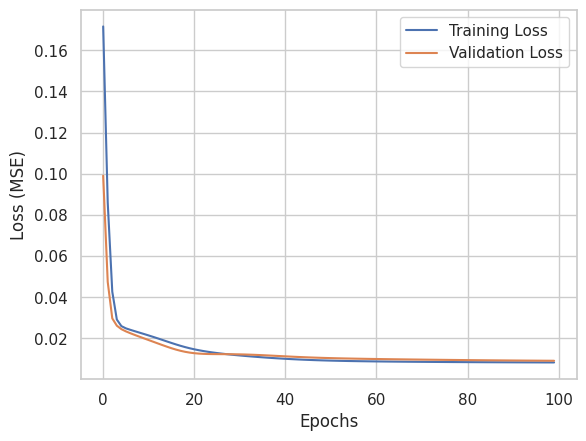

In [74]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


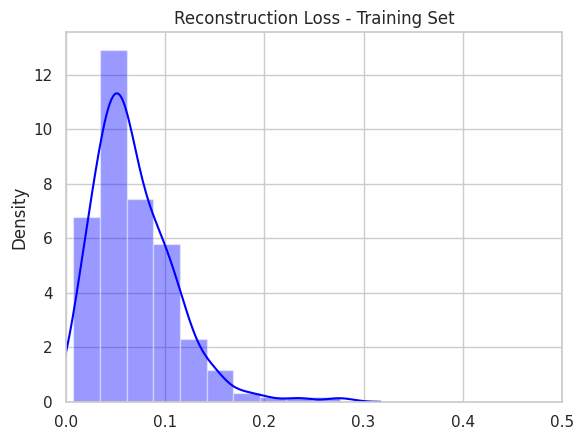

In [75]:
X_train_pred = autoencoder.predict(X_train)
train_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.figure()
sns.distplot(train_loss, bins=10, kde=True, color='blue')
plt.title("Reconstruction Loss - Training Set")
plt.xlim([0.0, 0.5])
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


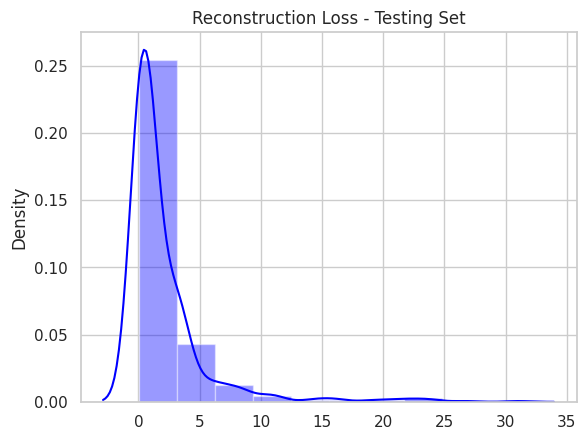

In [76]:
X_test_pred = autoencoder.predict(X_test)
test_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
plt.figure()
sns.distplot(test_loss, bins=10, kde=True, color='blue')
plt.title("Reconstruction Loss - Testing Set")
plt.show()

In [77]:
combined_loss = np.concatenate([train_loss, test_loss])
def calc_combined_threshold(loss, extreme=False):
    k = 3 if extreme else 2
    return np.mean(loss) + k * np.std(loss)

In [78]:
threshold_combined = calc_combined_threshold(combined_loss, extreme=True)
print(f"Combined Threshold for Anomalies: {threshold_combined}")

Combined Threshold for Anomalies: 11.51771046040515


In [79]:
reconstruction_errors = pd.DataFrame(index=X_train.index.append(X_test.index))
reconstruction_errors['Reconstruction Error'] = np.concatenate([train_loss, test_loss])
reconstruction_errors['Anomaly'] = reconstruction_errors['Reconstruction Error'] > threshold_combined

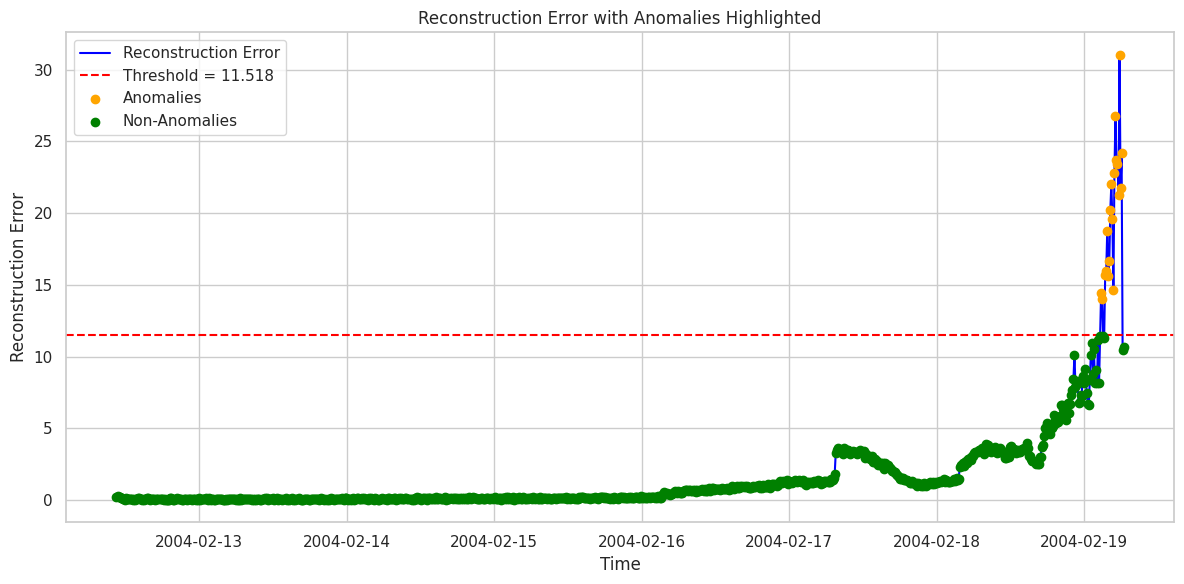

In [80]:
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors.index, reconstruction_errors['Reconstruction Error'], label='Reconstruction Error', color='blue')
plt.axhline(y=threshold_combined, color='red', linestyle='--', label=f'Threshold = {threshold_combined:.3f}')
anomalies_combined = reconstruction_errors[reconstruction_errors['Anomaly'] == True]
plt.scatter(anomalies_combined.index, anomalies_combined['Reconstruction Error'], color='orange', label='Anomalies', zorder=5)
non_anomalies_combined = reconstruction_errors[reconstruction_errors['Anomaly'] == False]
plt.scatter(non_anomalies_combined.index, non_anomalies_combined['Reconstruction Error'], color='green', label='Non-Anomalies', zorder=5)
plt.title('Reconstruction Error with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [81]:
if merged_data.index.duplicated().any():
    merged_data = merged_data[~merged_data.index.duplicated(keep='first')]

if reconstruction_errors.index.duplicated().any():
    reconstruction_errors = reconstruction_errors[~reconstruction_errors.index.duplicated(keep='first')]

reconstruction_errors_aligned = reconstruction_errors.reindex(merged_data.index)
merged_data['Anomaly'] = reconstruction_errors_aligned['Anomaly']

In [85]:
merged_data.to_csv('AnomalyDetection/BearingTest_2_Anomalies.csv')

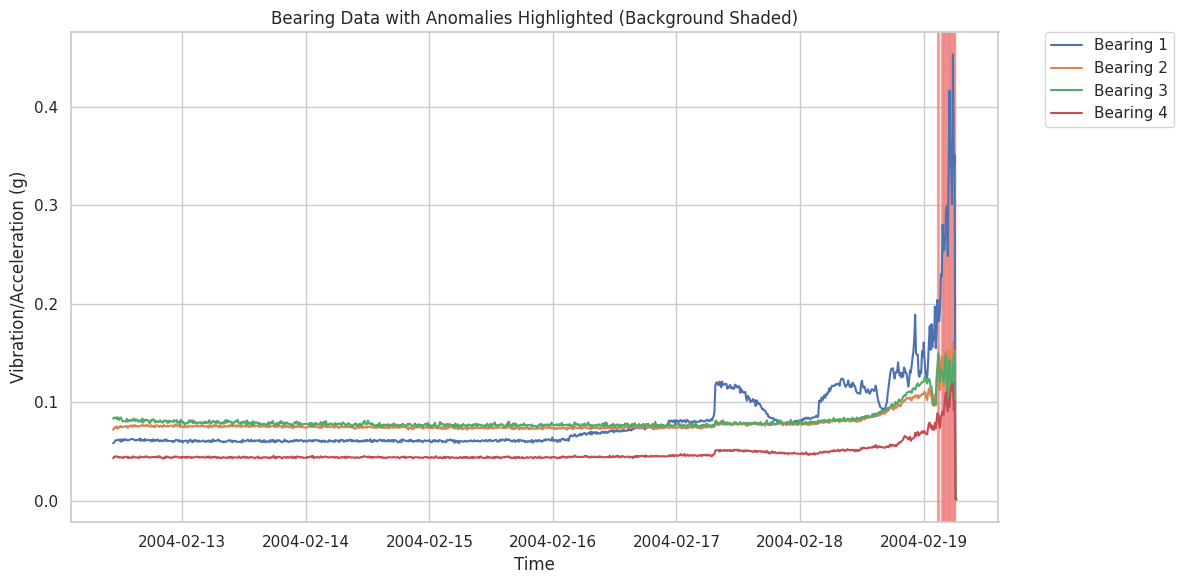

In [87]:
plt.figure(figsize=(12, 6))

for col in merged_data.columns[:-1]:
    plt.plot(merged_data.index, merged_data[col], label=col)

for i in range(len(merged_data)):
    if merged_data['Anomaly'].iloc[i]:
        plt.axvspan(merged_data.index[i], merged_data.index[i + 1], color='lightcoral', alpha=0.5)

plt.title("Bearing Data with Anomalies Highlighted in Red")
plt.xlabel("Time")
plt.ylabel("Vibration/Acceleration (g)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


For the majority of the time period, all four bearings exhibit stable vibration/acceleration values with very little fluctuation. This is evident from the flat lines for each bearing across most of the plot, particularly between February 12 and February 18, 2004.

- Around February 18-19, 2004, there is a significant increase in vibration/acceleration for Bearing 1 (shown in blue). This is consistent with the description of outer race failure in Bearing 1 towards the end of the test. The sharp rise in vibration indicates that the bearing started to deteriorate and eventually failed. The description specifies that an outer race failure occurred in Bearing 1 at the end of the test. This matches the behavior seen in the plot, where Bearing 1’s acceleration spikes dramatically in the final stages, consistent with the onset of mechanical failure.